# Final Project
Logan Cooper

In [99]:
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLSResults
from typing import Tuple
import geopandas

## Data

### Data Import

#### NCDB Building Age Data (2000)

In [100]:
ncdb_dtypes = {
    'tract_id': str,
    'workers_taking_transit': int,
    'prop_taking_transit': float,
    'built_1999_2000': int,
    'built_1995_1998': int,
    'built_1990_1994': int,
    'built_1980_1989': int,
    'built_1970_79': int,
    'built_1960_69': int,
    'built_1950_59': int,
    'built_1940_49': int,
    'built_1939_earlier': int
}
ncdb_data = pd.read_csv('./data/NCDB_2000.csv', dtype=ncdb_dtypes)
ncdb_data

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180


In [101]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier
2970,6001400100,124,0.091988,48,230,401,56,76,54,95,69,122
2971,6001400200,258,0.232014,0,0,10,18,26,62,31,94,658
2972,6001400300,700,0.226904,7,29,8,49,255,179,206,206,1628
2973,6001400400,450,0.204360,0,13,0,43,88,139,222,146,1229
2974,6001400500,395,0.213629,0,4,5,40,57,133,216,226,920
...,...,...,...,...,...,...,...,...,...,...,...,...
10014,6115040800,0,0.000000,22,54,127,209,231,182,132,57,135
10015,6115040901,5,0.005688,43,29,183,201,153,99,69,52,61
10016,6115040902,18,0.006529,7,123,46,176,303,685,436,67,7
10017,6115041000,6,0.002308,49,140,394,548,629,237,177,120,158


In [102]:
ncdb_data['pub_trans_gt_10pct'] = 0
ncdb_data['pub_trans_gt_10pct'][ncdb_data['prop_taking_transit'] >= 0.1] = 1
ncdb_data

/tmp/ipykernel_2697/1206332841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncdb_data['pub_trans_gt_10pct'][ncdb_data['prop_taking_transit'] >= 0.1] = 1


,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39,0
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119,0
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39,0
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10,0
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189,0
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241,0
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60,0
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180,0


In [103]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
2970,6001400100,124,0.091988,48,230,401,56,76,54,95,69,122,0
2971,6001400200,258,0.232014,0,0,10,18,26,62,31,94,658,1
2972,6001400300,700,0.226904,7,29,8,49,255,179,206,206,1628,1
2973,6001400400,450,0.204360,0,13,0,43,88,139,222,146,1229,1
2974,6001400500,395,0.213629,0,4,5,40,57,133,216,226,920,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10014,6115040800,0,0.000000,22,54,127,209,231,182,132,57,135,0
10015,6115040901,5,0.005688,43,29,183,201,153,99,69,52,61,0
10016,6115040902,18,0.006529,7,123,46,176,303,685,436,67,7,0
10017,6115041000,6,0.002308,49,140,394,548,629,237,177,120,158,0


In [104]:
ncdb_data['pub_trans_gt_10pct'].value_counts()

0    55450
1     9993
Name: pub_trans_gt_10pct, dtype: int64

In [105]:
ncdb_data

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39,0
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119,0
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39,0
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10,0
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189,0
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241,0
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60,0
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180,0


#### Tract Level Data (2019)

In [106]:
# import & rename cols
tract_data_2019 = pd.read_json('./data/tract_data_2019.json', dtype=False)
tract_data_2019.rename({
    'B19019_001E': 'median_income',
    'B01003_001E': 'population'
}, inplace=True, axis=1)

tract_data_2019['tract_id'] = tract_data_2019['state'] + tract_data_2019['county'] + tract_data_2019['tract']
tract_data_2019

,median_income,population,state,county,tract,tract_id
0,37030.0,4781.0,01,073,001100,01073001100
1,36066.0,1946.0,01,073,001400,01073001400
2,27159.0,4080.0,01,073,002000,01073002000
3,38721.0,5291.0,01,073,003802,01073003802
4,18525.0,2533.0,01,073,004000,01073004000
...,...,...,...,...,...,...
72872,87794.0,4187.0,56,021,001902,56021001902
72873,-666666666.0,0.0,56,021,980801,56021980801
72874,85194.0,7513.0,56,025,001602,56025001602
72875,120564.0,3724.0,56,025,001603,56025001603


In [107]:
tract_data_2019['state'].value_counts().sort_index()

01    1181
02     167
04    1526
05     686
06    8057
08    1249
09     833
10     218
12    4245
13    1969
15     351
16     298
17    3123
18    1511
19     825
20     770
21    1115
22    1148
23     358
24    1406
25    1478
26    2813
27    1338
28     664
29    1393
30     271
31     532
32     687
33     295
34    2010
35     499
36    4918
37    2195
38     205
39    2952
40    1046
41     834
42    3218
44     244
45    1103
46     222
47    1497
48    5265
49     588
50     184
51    1907
53    1458
54     484
55    1409
56     132
Name: state, dtype: int64

#### MSA-Level Income Data (2019)

In [108]:
msa_data = pd.read_json('./data/msa_data.json')
msa_data.columns = ['name', 'median_income', 'msa_code']
msa_data['msa_code'] = msa_data['msa_code'].astype(str)
msa_data

,name,median_income,msa_code
1,"Billings, MT Metro Area",61278,13740
2,"Binghamton, NY Metro Area",54295,13780
3,"Birmingham-Hoover, AL Metro Area",57447,13820
4,"Bismarck, ND Metro Area",71398,13900
6,"Blacksburg-Christiansburg, VA Metro Area",55065,13980
...,...,...,...
928,"Youngstown-Warren-Boardman, OH-PA Metro Area",47360,49660
929,"Yuba City, CA Metro Area",58551,49700
930,"Yuma, AZ Metro Area",45243,49740
935,"Orlando-Kissimmee-Sanford, FL Metro Area",58368,36740


In [109]:
msa_data = msa_data[msa_data['name'].str.contains('Metro Area')]
msa_data

,name,median_income,msa_code
1,"Billings, MT Metro Area",61278,13740
2,"Binghamton, NY Metro Area",54295,13780
3,"Birmingham-Hoover, AL Metro Area",57447,13820
4,"Bismarck, ND Metro Area",71398,13900
6,"Blacksburg-Christiansburg, VA Metro Area",55065,13980
...,...,...,...
928,"Youngstown-Warren-Boardman, OH-PA Metro Area",47360,49660
929,"Yuba City, CA Metro Area",58551,49700
930,"Yuma, AZ Metro Area",45243,49740
935,"Orlando-Kissimmee-Sanford, FL Metro Area",58368,36740


In [110]:
# derived from an earlier notebook version where these MSA IDs turned up missing
# anything not in here is either in Puerto Rico or isn't an MSA in at least one period
changed_msa_ids = ['19380','29140','42260','31100','22460','11340','11300','14060','42060','26180','23020','39140']
changed_msa_names = ['Dayton-Kettering, OH Metro Area', 
                     'Lafayette-West Lafayette, IN Metro Area', 
                     'North Port-Sarasota-Bradenton, FL Metro Area',
                     'Los Angeles-Long Beach-Anaheim, CA Metro Area',
                     'Florence-Muscle Shoals, AL Metro Area',
                     'Greenville-Anderson, SC Metro Area',
                     'Indianapolis-Carmel-Anderson, IN Metro Area',
                     'Bloomington, IL Metro Area',
                     'Santa Maria-Santa Barbara, CA Metro Area',
                     'Urban Honolulu, HI Metro Area',
                     'Crestview-Fort Walton Beach-Destin, FL Metro Area',
                     'Prescott Valley-Prescott, AZ Metro Area']

msa_data.loc[msa_data['name'].isin(changed_msa_names), 'msa_code'] = changed_msa_ids
msa_data[msa_data['msa_code'].isin(changed_msa_ids)]


,name,median_income,msa_code
7,"Bloomington, IL Metro Area",67675,19380
120,"Crestview-Fort Walton Beach-Destin, FL Metro Area",62161,29140
144,"Dayton-Kettering, OH Metro Area",55634,42260
212,"Florence-Muscle Shoals, AL Metro Area",48084,31100
260,"Greenville-Anderson, SC Metro Area",54886,22460
310,"Indianapolis-Carmel-Anderson, IN Metro Area",61552,11340
497,"Prescott Valley-Prescott, AZ Metro Area",52451,11300
585,"Santa Maria-Santa Barbara, CA Metro Area",74624,14060
672,"Urban Honolulu, HI Metro Area",85857,42060
722,"Lafayette-West Lafayette, IN Metro Area",53321,26180


In [111]:
msa_data.to_json('./data/msa_data.json')

#### MSA-Tract Crosswalk

In [112]:
msa_lookup = pd.read_excel('./data/omb-cbsa-csa.xls')
msa_lookup = msa_lookup.iloc[2:].dropna(axis=1).iloc[:, [0, 2, -1]].reset_index(drop=True).dropna()
msa_lookup.columns = ['CBSA Code', 'Metropolitan/Micropolitan Statistical Area', 'FIPS Code']

for c in msa_lookup.columns:
    msa_lookup[c] = msa_lookup[c].astype(str)

msa_lookup

,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS Code
0,10020,Micropolitan Statistical Area,22113
1,10100,Micropolitan Statistical Area,46013
2,10100,Micropolitan Statistical Area,46045
3,10140,Micropolitan Statistical Area,53027
4,10180,Metropolitan Statistical Area,48059
...,...,...,...
1832,49660,Metropolitan Statistical Area,42085
1833,49700,Metropolitan Statistical Area,06101
1834,49700,Metropolitan Statistical Area,06115
1835,49740,Metropolitan Statistical Area,04027


In [113]:
msa_lookup['FIPS State Code'] = msa_lookup['FIPS Code'].str[:2]
msa_lookup['FIPS County Code'] = msa_lookup['FIPS Code'].str[2:]
msa_lookup.drop('FIPS Code', axis=1, inplace=True)
msa_lookup

,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,10020,Micropolitan Statistical Area,22,113
1,10100,Micropolitan Statistical Area,46,013
2,10100,Micropolitan Statistical Area,46,045
3,10140,Micropolitan Statistical Area,53,027
4,10180,Metropolitan Statistical Area,48,059
...,...,...,...,...
1832,49660,Metropolitan Statistical Area,42,085
1833,49700,Metropolitan Statistical Area,06,101
1834,49700,Metropolitan Statistical Area,06,115
1835,49740,Metropolitan Statistical Area,04,027


In [114]:
og_msas = msa_lookup[msa_lookup['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']['CBSA Code'].value_counts().index
og_msas

Index(['41980', '12060', '35620', '47900', '40060', '47260', '41180', '17140',
       '28140', '16980',
       ...
       '19660', '20100', '34580', '34620', '34740', '34820', '34900', '34940',
       '35300', '49740'],
      dtype='object', length=370)

In [115]:
# msa_lookup = pd.read_excel('./data/msa_codes.xls', 
#                            converters={'CBSA Code': str, 
#                                        'CBSA Title': str, 
#                                        'Metropolitan/Micropolitan Statistical Area': str, 
#                                        'FIPS State Code': str,
#                                        'FIPS County Code': str}
#                            ).drop(range(1916,1920))

# msa_lookup

#### Conversion for 2000 => 2010

In [116]:
tract_conversion = pd.read_csv('./data/us2010trf.txt')
tract_conversion

,STATE00,COUNTY00,TRACT00,GEOID00,POP00,HU00,PART00,AREA00,AREALAND00,STATE10,...,AREAPCT00PT,AREALANDPCT00PT,AREAPCT10PT,AREALANDPCT10PT,POP10PT,POPPCT00,POPPCT10,HU10PT,HUPCT00,HUPCT10
0,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,99.99,100.00,100.00,100.00,1912,99.95,100.00,752,99.87,100.00
1,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,0.01,0.00,0.01,0.00,0,0.00,0.00,0,0.00,0.00
2,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,0.00,0.00,0.00,0.00,1,0.05,0.01,1,0.13,0.02
3,1,1,20200,1001020200,2170,822,W,3346351,3340505,1,...,100.00,100.00,100.00,100.00,2170,100.00,100.00,822,100.00,100.00
4,1,1,20300,1001020300,3373,1326,W,5358328,5349274,1,...,100.00,100.00,100.00,100.00,3373,100.00,100.00,1326,100.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110849,72,153,750601,72153750601,5315,2106,P,11040535,11035996,72,...,99.79,99.79,100.00,100.00,5315,100.00,100.00,2106,100.00,100.00
110850,72,153,750601,72153750601,5315,2106,P,11040535,11035996,72,...,0.21,0.21,0.13,0.13,0,0.00,0.00,0,0.00,0.00
110851,72,153,750602,72153750602,3141,1450,P,17773730,17520777,72,...,0.04,0.04,0.05,0.05,0,0.00,0.00,0,0.00,0.00
110852,72,153,750602,72153750602,3141,1450,P,17773730,17520777,72,...,0.06,0.07,0.04,0.05,0,0.00,0.00,0,0.00,0.00


In [117]:
tract_conversion.columns

Index(['STATE00', 'COUNTY00', 'TRACT00', 'GEOID00', 'POP00', 'HU00', 'PART00',
       'AREA00', 'AREALAND00', 'STATE10', 'COUNTY10', 'TRACT10', 'GEOID10',
       'POP10', 'HU10', 'PART10', 'AREA10', 'AREALAND10', 'AREAPT',
       'AREALANDPT', 'AREAPCT00PT', 'AREALANDPCT00PT', 'AREAPCT10PT',
       'AREALANDPCT10PT', 'POP10PT', 'POPPCT00', 'POPPCT10', 'HU10PT',
       'HUPCT00', 'HUPCT10'],
      dtype='object')

In [118]:
tract_conversion = tract_conversion[['GEOID00', 'GEOID10', 'AREALAND10']]
tract_conversion['GEOID00'] = tract_conversion['GEOID00'].astype(str)
tract_conversion['GEOID10'] = tract_conversion['GEOID10'].astype(str)
tract_conversion

/tmp/ipykernel_2697/1172295500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['GEOID00'] = tract_conversion['GEOID00'].astype(str)
/tmp/ipykernel_2697/1172295500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['GEOID10'] = tract_conversion['GEOID10'].astype(str)


,GEOID00,GEOID10,AREALAND10
0,1001020100,1001020100,9809944
1,1001020100,1001020600,8020366
2,1001020100,1001020802,190810921
3,1001020200,1001020200,3340505
4,1001020300,1001020300,5349274
...,...,...,...
110849,72153750601,72153750601,11012462
110850,72153750601,72153750602,17526535
110851,72153750602,72055960900,13138821
110852,72153750602,72055961100,24581786


In [119]:
# AREALAND10 is in square meters, want it in square miles
tract_conversion['AREALAND10'] = tract_conversion['AREALAND10'] * 3.861e-7
tract_conversion = tract_conversion[tract_conversion['AREALAND10'] > 0]
tract_conversion

/tmp/ipykernel_2697/534912662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['AREALAND10'] = tract_conversion['AREALAND10'] * 3.861e-7


,GEOID00,GEOID10,AREALAND10
0,1001020100,1001020100,3.787619
1,1001020100,1001020600,3.096663
2,1001020100,1001020802,73.672097
3,1001020200,1001020200,1.289769
4,1001020300,1001020300,2.065355
...,...,...,...
110849,72153750601,72153750601,4.251912
110850,72153750601,72153750602,6.766995
110851,72153750602,72055960900,5.072899
110852,72153750602,72055961100,9.491028


#### Tract-School District Crosswalk

In [120]:
school_districts = pd.read_excel('./data/grf19_lea_tract.xlsx')
# school_districts.drop(['NAME_LEA19', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
school_districts['LEAID'] = school_districts['LEAID'].astype(str)
school_districts['TRACT'] = school_districts['TRACT'].astype(str)
school_districts

,LEAID,NAME_LEA19,TRACT,COUNT,LANDAREA,WATERAREA
0,100001,Fort Rucker School District,1031010300,2,23.428498,0.000000
1,100001,Fort Rucker School District,1045020000,2,66.513225,1.081745
2,100003,Maxwell AFB School District,1101000900,3,3.356590,0.143795
3,100003,Maxwell AFB School District,1101001000,3,0.001526,0.000000
4,100003,Maxwell AFB School District,1101006000,3,0.003588,0.000000
...,...,...,...,...,...,...
113515,7800030,Virgin Islands Department of Education,78030960900,32,3.147245,1.173777
113516,7800030,Virgin Islands Department of Education,78030961000,32,0.812847,0.910606
113517,7800030,Virgin Islands Department of Education,78030961100,32,1.356638,0.000000
113518,7800030,Virgin Islands Department of Education,78030961200,32,0.392958,0.309706


#### Wilson CBD

In [121]:
wilson_cbd = pd.read_csv('./data/wilson_cbd.csv', index_col=False, dtype={'msa_id': str, 'wilson_cbd': str})
wilson_cbd

,msa_id,wilson_cbd
0,10180,48441011000
1,10420,39153508301
2,10500,13095011400
3,10580,36001001100
4,10740,35001002100
...,...,...
363,49420,53077000100
364,49620,42133000100
365,49660,39099813700
366,49700,06101050604


## Data Combination

#### Trim Tract Level Data to MSAs Only

In [122]:
only_metros = msa_lookup[msa_lookup['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']
msa_tracts = pd.merge(left=tract_data_2019, right=only_metros, left_on=['state', 'county'], right_on=['FIPS State Code', 'FIPS County Code'])
msa_tracts

,median_income,population,state,county,tract,tract_id,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,37030.0,4781.0,01,073,001100,01073001100,13820,Metropolitan Statistical Area,01,073
1,36066.0,1946.0,01,073,001400,01073001400,13820,Metropolitan Statistical Area,01,073
2,27159.0,4080.0,01,073,002000,01073002000,13820,Metropolitan Statistical Area,01,073
3,38721.0,5291.0,01,073,003802,01073003802,13820,Metropolitan Statistical Area,01,073
4,18525.0,2533.0,01,073,004000,01073004000,13820,Metropolitan Statistical Area,01,073
...,...,...,...,...,...,...,...,...,...,...
59652,73795.0,4105.0,56,021,001401,56021001401,16940,Metropolitan Statistical Area,56,021
59653,65192.0,2671.0,56,021,001402,56021001402,16940,Metropolitan Statistical Area,56,021
59654,98949.0,5088.0,56,021,001901,56021001901,16940,Metropolitan Statistical Area,56,021
59655,87794.0,4187.0,56,021,001902,56021001902,16940,Metropolitan Statistical Area,56,021


In [123]:
msa_tracts = msa_tracts[(msa_tracts['median_income'] >= 0) & (msa_tracts['population'] > 0)]
msa_tracts

,median_income,population,state,county,tract,tract_id,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,37030.0,4781.0,01,073,001100,01073001100,13820,Metropolitan Statistical Area,01,073
1,36066.0,1946.0,01,073,001400,01073001400,13820,Metropolitan Statistical Area,01,073
2,27159.0,4080.0,01,073,002000,01073002000,13820,Metropolitan Statistical Area,01,073
3,38721.0,5291.0,01,073,003802,01073003802,13820,Metropolitan Statistical Area,01,073
4,18525.0,2533.0,01,073,004000,01073004000,13820,Metropolitan Statistical Area,01,073
...,...,...,...,...,...,...,...,...,...,...
59651,79224.0,8092.0,56,021,000501,56021000501,16940,Metropolitan Statistical Area,56,021
59652,73795.0,4105.0,56,021,001401,56021001401,16940,Metropolitan Statistical Area,56,021
59653,65192.0,2671.0,56,021,001402,56021001402,16940,Metropolitan Statistical Area,56,021
59654,98949.0,5088.0,56,021,001901,56021001901,16940,Metropolitan Statistical Area,56,021


In [124]:
msa_tracts['state'].value_counts().sort_index()

01     820
02      98
04    1342
05     391
06    7766
08    1048
09     747
10     161
12    3888
13    1520
15     229
16     181
17    2636
18    1152
19     423
20     452
21     623
22     850
23     188
24    1313
25    1445
26    2213
27     929
28     283
29     981
30      79
31     295
32     607
33     174
34    1992
35     325
36    4375
37    1491
38      75
39    2411
40     681
41     619
42    2688
44     240
45     829
46      88
47    1070
48    4432
49     515
50      46
51    1605
53    1241
54     267
55     990
56      38
Name: state, dtype: int64

In [125]:
msa_tracts['CBSA Code'].value_counts()

35620    4447
31100    2890
16980    2201
37980    1460
19100    1310
         ... 
14980      17
25980      16
30300      16
18020      15
16180      13
Name: CBSA Code, Length: 362, dtype: int64

In [126]:
pr_msas = [el for el in og_msas if (el not in msa_tracts['CBSA Code'].value_counts().index)] #okay looks like these are all in PR
pr_msas

['41980', '10380', '49500', '41900', '25020', '38660', '21940', '32420']

In [127]:
msa_tracts.columns

Index(['median_income', 'population', 'state', 'county', 'tract', 'tract_id',
       'CBSA Code', 'Metropolitan/Micropolitan Statistical Area',
       'FIPS State Code', 'FIPS County Code'],
      dtype='object')

In [128]:
msa_tracts.drop(['Metropolitan/Micropolitan Statistical Area', 'FIPS State Code', 'FIPS County Code'], axis=1, inplace=True)
msa_tracts

/tmp/ipykernel_2697/1112801136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msa_tracts.drop(['Metropolitan/Micropolitan Statistical Area', 'FIPS State Code', 'FIPS County Code'], axis=1, inplace=True)


,median_income,population,state,county,tract,tract_id,CBSA Code
0,37030.0,4781.0,01,073,001100,01073001100,13820
1,36066.0,1946.0,01,073,001400,01073001400,13820
2,27159.0,4080.0,01,073,002000,01073002000,13820
3,38721.0,5291.0,01,073,003802,01073003802,13820
4,18525.0,2533.0,01,073,004000,01073004000,13820
...,...,...,...,...,...,...,...
59651,79224.0,8092.0,56,021,000501,56021000501,16940
59652,73795.0,4105.0,56,021,001401,56021001401,16940
59653,65192.0,2671.0,56,021,001402,56021001402,16940
59654,98949.0,5088.0,56,021,001901,56021001901,16940


In [129]:
del only_metros
gc.collect()

113646

#### Merge MSA-Level Data

In [130]:
msa_tracts = pd.merge(left=msa_tracts, right=msa_data, left_on='CBSA Code', right_on='msa_code', suffixes=('_tract', '_msa'))
msa_tracts['income'] = msa_tracts['median_income_tract'] / msa_tracts['median_income_msa']
msa_tracts.drop(['CBSA Code', 'median_income_tract', 'median_income_msa'], axis=1, inplace=True)
msa_tracts

,population,state,county,tract,tract_id,name,msa_code,income
0,4781.0,01,073,001100,01073001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594
1,1946.0,01,073,001400,01073001400,"Birmingham-Hoover, AL Metro Area",13820,0.627813
2,4080.0,01,073,002000,01073002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766
3,5291.0,01,073,003802,01073003802,"Birmingham-Hoover, AL Metro Area",13820,0.674030
4,2533.0,01,073,004000,01073004000,"Birmingham-Hoover, AL Metro Area",13820,0.322471
...,...,...,...,...,...,...,...,...
58150,8092.0,56,021,000501,56021000501,"Cheyenne, WY Metro Area",16940,1.184038
58151,4105.0,56,021,001401,56021001401,"Cheyenne, WY Metro Area",16940,1.102899
58152,2671.0,56,021,001402,56021001402,"Cheyenne, WY Metro Area",16940,0.974324
58153,5088.0,56,021,001901,56021001901,"Cheyenne, WY Metro Area",16940,1.478837


In [131]:
[el for el in og_msas if (el not in msa_tracts['msa_code'].value_counts().index) and (el not in pr_msas)]

['26900', '24860', '14980', '37700', '19260', '46940', '41780', '26100']

In [132]:
msa_tracts['state'].value_counts().sort_index()

01     820
02      98
04    1342
05     391
06    7766
08    1048
09     747
10     161
12    3859
13    1520
15     229
16     181
17    2636
18     792
19     423
20     452
21     623
22     850
23     188
24    1313
25    1445
26    2160
27     929
28     250
29     981
30      79
31     295
32     607
33     174
34    1992
35     325
36    4375
37    1491
38      75
39    2393
40     681
41     619
42    2688
44     240
45     673
46      88
47    1070
48    4432
49     515
50      46
51    1557
53    1241
54     267
55     990
56      38
Name: state, dtype: int64

In [133]:
# msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'] = msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'].str[1:]

In [134]:
del msa_data
gc.collect()

0

#### Convert 2000-Tracts and Merge

In [135]:
ages_2019 = pd.merge(left=ncdb_data, right=tract_conversion, left_on='tract_id', right_on='GEOID00')
ages_2019.drop(['tract_id', 'workers_taking_transit', 'prop_taking_transit'], axis=1, inplace=True)
ages_2019.rename({'AREALAND10': 'area', 'GEOID10': 'tract_id_2010', 'GEOID00': 'tract_id_2000'}, inplace=True, axis=1)

ages_2019

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,tract_id_2000,tract_id_2010,area
0,28,71,67,137,214,94,59,33,39,0,1001020100,1001020100,3.787619
1,28,71,67,137,214,94,59,33,39,0,1001020100,1001020600,3.096663
2,28,71,67,137,214,94,59,33,39,0,1001020100,1001020802,73.672097
3,21,47,39,102,220,83,75,52,119,0,1001020200,1001020200,1.289769
4,24,176,72,150,389,328,31,54,39,0,1001020300,1001020300,2.065355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108049,7,29,27,152,487,82,152,39,60,0,56043000302,56043000302,5.894123
108050,64,101,81,280,412,124,139,113,180,0,56045951100,46033965100,1524.284426
108051,64,101,81,280,412,124,139,113,180,0,56045951100,56011950200,2008.869910
108052,64,101,81,280,412,124,139,113,180,0,56045951100,56045951100,2355.294496


In [136]:
non_aggregated_tract_data = ages_2019[['tract_id_2010', 'area']].drop_duplicates()
non_aggregated_tract_data

,tract_id_2010,area
0,1001020100,3.787619
1,1001020600,3.096663
2,1001020802,73.672097
3,1001020200,1.289769
4,1001020300,2.065355
...,...,...
108045,56041975400,51.087489
108047,56043000301,0.769575
108048,56043000302,5.894123
108052,56045951100,2355.294496


In [137]:
summed_ages = ages_2019.groupby('tract_id_2010').sum(numeric_only=True).drop(['area'], axis=1).reset_index()
summed_ages

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,10001040100,74,238,301,502,450,126,46,33,134,0
1,10001040201,61,114,87,105,299,229,131,87,336,0
2,10001040202,41,198,211,368,364,242,163,94,339,0
3,10001040203,16,223,191,207,163,152,145,34,95,0
4,10001040501,175,527,413,404,786,789,294,89,126,0
...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0
72735,9015907100,27,133,139,472,502,454,334,209,1373,0
72736,9015907200,0,72,66,210,320,275,235,117,733,0
72737,9015907300,14,100,90,398,322,346,148,121,494,0


In [138]:
summed_ages['pub_trans_gt_10pct'] = (summed_ages['pub_trans_gt_10pct'] >= 1).astype(int)
summed_ages

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,10001040100,74,238,301,502,450,126,46,33,134,0
1,10001040201,61,114,87,105,299,229,131,87,336,0
2,10001040202,41,198,211,368,364,242,163,94,339,0
3,10001040203,16,223,191,207,163,152,145,34,95,0
4,10001040501,175,527,413,404,786,789,294,89,126,0
...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0
72735,9015907100,27,133,139,472,502,454,334,209,1373,0
72736,9015907200,0,72,66,210,320,275,235,117,733,0
72737,9015907300,14,100,90,398,322,346,148,121,494,0


In [139]:
summed_ages.describe()

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
count,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000
mean,86.584075,255.289171,241.975831,490.126782,528.749804,370.581298,331.683045,186.090983,388.802293,0.152325
std,169.292508,410.716050,331.594439,578.283644,508.355353,351.777010,352.244631,214.831011,553.901444,0.359339
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,24.000000,33.000000,105.000000,173.000000,134.000000,102.000000,44.000000,44.000000,0.000000
50%,28.000000,106.000000,121.000000,298.000000,389.000000,271.000000,228.000000,124.000000,188.000000,0.000000
75%,96.000000,320.000000,322.000000,674.000000,728.000000,495.000000,439.000000,251.000000,519.000000,0.000000
max,4918.000000,8456.000000,4639.000000,11267.000000,10034.000000,8417.000000,5537.000000,8296.000000,10131.000000,1.000000


In [140]:
msa_tracts['tract_id'] = msa_tracts['tract_id'].str.removeprefix('0')
msa_tracts['tract_id']

0         1073001100
1         1073001400
2         1073002000
3         1073003802
4         1073004000
            ...     
58150    56021000501
58151    56021001401
58152    56021001402
58153    56021001901
58154    56021001902
Name: tract_id, Length: 58155, dtype: object

In [141]:
ages_2019 = pd.merge(left=summed_ages, right=non_aggregated_tract_data)
ages_2019

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area
0,10001040100,74,238,301,502,450,126,46,33,134,0,48.164373
1,10001040201,61,114,87,105,299,229,131,87,336,0,3.757499
2,10001040202,41,198,211,368,364,242,163,94,339,0,12.333051
3,10001040203,16,223,191,207,163,152,145,34,95,0,22.927105
4,10001040501,175,527,413,404,786,789,294,89,126,0,4.040981
...,...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0,39.944555
72735,9015907100,27,133,139,472,502,454,334,209,1373,0,13.248126
72736,9015907200,0,72,66,210,320,275,235,117,733,0,13.477847
72737,9015907300,14,100,90,398,322,346,148,121,494,0,15.633260


In [142]:
ages_2019.describe()

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area
count,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000
mean,86.584075,255.289171,241.975831,490.126782,528.749804,370.581298,331.683045,186.090983,388.802293,0.152325,48.555597
std,169.292508,410.716050,331.594439,578.283644,508.355353,351.777010,352.244631,214.831011,553.901444,0.359339,542.923463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003204
25%,5.000000,24.000000,33.000000,105.000000,173.000000,134.000000,102.000000,44.000000,44.000000,0.000000,0.694460
50%,28.000000,106.000000,121.000000,298.000000,389.000000,271.000000,228.000000,124.000000,188.000000,0.000000,1.890971
75%,96.000000,320.000000,322.000000,674.000000,728.000000,495.000000,439.000000,251.000000,519.000000,0.000000,13.309841
max,4918.000000,8456.000000,4639.000000,11267.000000,10034.000000,8417.000000,5537.000000,8296.000000,10131.000000,1.000000,85425.253710


In [143]:
msa_tracts = pd.merge(left=msa_tracts, right=ages_2019, left_on='tract_id', right_on='tract_id_2010')
msa_tracts.drop(['tract_id'], axis=1, inplace=True)

msa_tracts = msa_tracts[(msa_tracts['population'] >= 1) & (msa_tracts['income'] > 0) & (msa_tracts['area'] > 0)] # drop weird tracts

msa_tracts['pop_density'] = msa_tracts['population'] / msa_tracts['area']
msa_tracts

,population,state,county,tract,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density
0,4781.0,01,073,001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,4.412472,1083.519710
1,1946.0,01,073,001400,"Birmingham-Hoover, AL Metro Area",13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,0.865361,2248.772710
2,4080.0,01,073,002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,1.391900,2931.244740
3,5291.0,01,073,003802,"Birmingham-Hoover, AL Metro Area",13820,0.674030,1073003802,46,76,22,184,603,968,2195,919,574,0,1.252927,4222.913159
4,2533.0,01,073,004000,"Birmingham-Hoover, AL Metro Area",13820,0.322471,1073004000,18,31,66,352,617,554,207,191,244,0,0.913001,2774.367116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58129,8092.0,56,021,000501,"Cheyenne, WY Metro Area",16940,1.184038,56021000501,94,376,78,304,497,911,204,31,17,0,2.358055,3431.641507
58130,4105.0,56,021,001401,"Cheyenne, WY Metro Area",16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,1.541849,2662.387090
58131,2671.0,56,021,001402,"Cheyenne, WY Metro Area",16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,4.889134,546.313507
58132,5088.0,56,021,001901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,585.414185,8.691282


In [144]:
msa_tracts['state'].value_counts().sort_index()

01     820
02      98
04    1335
05     391
06    7765
08    1048
09     747
10     161
12    3859
13    1520
15     229
16     181
17    2636
18     792
19     423
20     452
21     623
22     850
23     188
24    1313
25    1445
26    2160
27     929
28     250
29     981
30      79
31     295
32     607
33     174
34    1992
35     325
36    4363
37    1491
38      75
39    2393
40     681
41     619
42    2688
44     240
45     673
46      88
47    1070
48    4432
49     515
50      46
51    1556
53    1241
54     267
55     990
56      38
Name: state, dtype: int64

In [145]:
del ages_2019
gc.collect()

0

#### Add School District

In [146]:
msa_tracts = pd.merge(left=msa_tracts, right=school_districts, left_on='tract_id_2010', right_on='TRACT')
msa_tracts.drop(['NAME_LEA19', 'TRACT', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
msa_tracts

,population,state,county,tract,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,...,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID
0,4781.0,01,073,001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,...,788,1570,919,854,759,596,0,4.412472,1083.519710,100390
1,4781.0,01,073,001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,...,788,1570,919,854,759,596,0,4.412472,1083.519710,101920
2,1946.0,01,073,001400,"Birmingham-Hoover, AL Metro Area",13820,0.627813,1073001400,15,27,...,290,422,894,1393,601,1126,0,0.865361,2248.772710,100390
3,4080.0,01,073,002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,...,172,490,746,717,520,388,0,1.391900,2931.244740,100390
4,4080.0,01,073,002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,...,172,490,746,717,520,388,0,1.391900,2931.244740,101920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82167,4105.0,56,021,001401,"Cheyenne, WY Metro Area",16940,1.102899,56021001401,68,244,...,502,867,425,195,0,18,0,1.541849,2662.387090,5601980
82168,2671.0,56,021,001402,"Cheyenne, WY Metro Area",16940,0.974324,56021001402,68,244,...,502,867,425,195,0,18,0,4.889134,546.313507,5601980
82169,5088.0,56,021,001901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,...,502,478,155,113,66,172,0,585.414185,8.691282,5601980
82170,5088.0,56,021,001901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,...,502,478,155,113,66,172,0,585.414185,8.691282,5604120


In [147]:
del school_districts
gc.collect()

0

### Add Wilson CBD

In [148]:
wilson_cbd

,msa_id,wilson_cbd
0,10180,48441011000
1,10420,39153508301
2,10500,13095011400
3,10580,36001001100
4,10740,35001002100
...,...,...
363,49420,53077000100
364,49620,42133000100
365,49660,39099813700
366,49700,06101050604


In [149]:
msa_tracts = pd.merge(left=msa_tracts, right=wilson_cbd, left_on='msa_code', right_on='msa_id')
msa_tracts.drop('msa_id', axis=1, inplace=True)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].str.removeprefix('0')
msa_tracts

,population,state,county,tract,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,...,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID,wilson_cbd
0,4781.0,01,073,001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,...,1570,919,854,759,596,0,4.412472,1083.519710,100390,1073002700
1,4781.0,01,073,001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,...,1570,919,854,759,596,0,4.412472,1083.519710,101920,1073002700
2,1946.0,01,073,001400,"Birmingham-Hoover, AL Metro Area",13820,0.627813,1073001400,15,27,...,422,894,1393,601,1126,0,0.865361,2248.772710,100390,1073002700
3,4080.0,01,073,002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,...,490,746,717,520,388,0,1.391900,2931.244740,100390,1073002700
4,4080.0,01,073,002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,...,490,746,717,520,388,0,1.391900,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82051,4105.0,56,021,001401,"Cheyenne, WY Metro Area",16940,1.102899,56021001401,68,244,...,867,425,195,0,18,0,1.541849,2662.387090,5601980,56021000700
82052,2671.0,56,021,001402,"Cheyenne, WY Metro Area",16940,0.974324,56021001402,68,244,...,867,425,195,0,18,0,4.889134,546.313507,5601980,56021000700
82053,5088.0,56,021,001901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,...,478,155,113,66,172,0,585.414185,8.691282,5601980,56021000700
82054,5088.0,56,021,001901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,...,478,155,113,66,172,0,585.414185,8.691282,5604120,56021000700


In [150]:
msa_tracts

,population,state,county,tract,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,...,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID,wilson_cbd
0,4781.0,01,073,001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,...,1570,919,854,759,596,0,4.412472,1083.519710,100390,1073002700
1,4781.0,01,073,001100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,...,1570,919,854,759,596,0,4.412472,1083.519710,101920,1073002700
2,1946.0,01,073,001400,"Birmingham-Hoover, AL Metro Area",13820,0.627813,1073001400,15,27,...,422,894,1393,601,1126,0,0.865361,2248.772710,100390,1073002700
3,4080.0,01,073,002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,...,490,746,717,520,388,0,1.391900,2931.244740,100390,1073002700
4,4080.0,01,073,002000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,...,490,746,717,520,388,0,1.391900,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82051,4105.0,56,021,001401,"Cheyenne, WY Metro Area",16940,1.102899,56021001401,68,244,...,867,425,195,0,18,0,1.541849,2662.387090,5601980,56021000700
82052,2671.0,56,021,001402,"Cheyenne, WY Metro Area",16940,0.974324,56021001402,68,244,...,867,425,195,0,18,0,4.889134,546.313507,5601980,56021000700
82053,5088.0,56,021,001901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,...,478,155,113,66,172,0,585.414185,8.691282,5601980,56021000700
82054,5088.0,56,021,001901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,...,478,155,113,66,172,0,585.414185,8.691282,5604120,56021000700


In [151]:
msa_tracts.to_csv('./data/msa_tracts.csv', index=False)

### Calculating Distances

#### Finding Central Business District

In [152]:
msa_tracts = pd.read_csv('./data/msa_tracts.csv', index_col=False)
msa_tracts.rename({'msa_code_tract': 'msa_code'}, axis=1, inplace=True)
msa_tracts.drop(['area', 'population'], inplace=True, axis=1)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].astype(str)
msa_tracts

,state,county,tract,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd
0,1,73,1100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,100390,1073002700
1,1,73,1100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,101920,1073002700
2,1,73,1400,"Birmingham-Hoover, AL Metro Area",13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,2248.772710,100390,1073002700
3,1,73,2000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,100390,1073002700
4,1,73,2000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82051,56,21,1401,"Cheyenne, WY Metro Area",16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,2662.387090,5601980,56021000700
82052,56,21,1402,"Cheyenne, WY Metro Area",16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,546.313507,5601980,56021000700
82053,56,21,1901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5601980,56021000700
82054,56,21,1901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5604120,56021000700


In [153]:
msa_tracts['msa_code'].value_counts()

35620    5339
16980    4167
31100    4146
19100    1914
19820    1694
         ... 
18020      19
21820      19
16220      18
25980      16
16180      13
Name: msa_code, Length: 350, dtype: int64

In [154]:
msa_tracts['state'].value_counts().sort_index()

1      1240
2        98
4      2280
5       716
6     13941
8      1298
9       771
10      220
12     3646
13     1668
15      229
16      304
17     5442
18      962
19      786
20      757
21      732
22      882
23      221
24     1313
25     1556
26     3357
27     1452
28      333
29     1701
30      300
31      475
32      607
33      206
34     2425
35      402
36     6055
37     1555
38      146
39     3620
40     1290
41      987
42     2837
44      245
45      796
46      188
47     1321
48     6581
49      602
50       48
51     1562
53     1928
54      253
55     1682
56       40
Name: state, dtype: int64

In [155]:
cbd_candidates = msa_tracts[['msa_code', 'tract_id_2010', 'pop_density']]
cbds = cbd_candidates.groupby('msa_code').max()
cbds.drop('pop_density', axis=1, inplace=True)
cbds.reset_index(inplace=True)
cbds

,msa_code,tract_id_2010
0,10180,48441013600
1,10420,39153534100
2,10500,13321950600
3,10580,36095740800
4,10740,35061971400
...,...,...
345,49420,53077940006
346,49620,42133024002
347,49660,42085033400
348,49700,6115041100


In [156]:
msa_tracts = pd.merge(left=msa_tracts, right=cbds, left_on='msa_code', right_on='msa_code', suffixes=('', 'cbd'))
msa_tracts.rename({'tract_id_2010cbd': 'br_cbd'}, inplace=True, axis=1)
msa_tracts['br_cbd'] = msa_tracts['br_cbd'].astype(str)
msa_tracts['tract_id_2010'] = msa_tracts['tract_id_2010'].astype(str)
msa_tracts

,state,county,tract,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,...,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd
0,1,73,1100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,1083.519710,100390,1073002700,1127021900
1,1,73,1100,"Birmingham-Hoover, AL Metro Area",13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,1083.519710,101920,1073002700,1127021900
2,1,73,1400,"Birmingham-Hoover, AL Metro Area",13820,0.627813,1073001400,15,27,30,...,422,894,1393,601,1126,0,2248.772710,100390,1073002700,1127021900
3,1,73,2000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,2931.244740,100390,1073002700,1127021900
4,1,73,2000,"Birmingham-Hoover, AL Metro Area",13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,2931.244740,101920,1073002700,1127021900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82051,56,21,1401,"Cheyenne, WY Metro Area",16940,1.102899,56021001401,68,244,155,...,867,425,195,0,18,0,2662.387090,5601980,56021000700,56021002000
82052,56,21,1402,"Cheyenne, WY Metro Area",16940,0.974324,56021001402,68,244,155,...,867,425,195,0,18,0,546.313507,5601980,56021000700,56021002000
82053,56,21,1901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,8.691282,5601980,56021000700,56021002000
82054,56,21,1901,"Cheyenne, WY Metro Area",16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,8.691282,5604120,56021000700,56021002000


In [157]:
msa_tracts['br_cbd'].str.len().value_counts()

11    62003
10    20053
Name: br_cbd, dtype: int64

In [158]:
msa_tracts['tract_id_2010'].str.len().value_counts()

11    61712
10    20344
Name: tract_id_2010, dtype: int64

#### Calculating Distances

In [159]:
def regularize_house_ages(df: pd.DataFrame) -> pd.DataFrame:
    age_cats = ['built_1999_2000',
       'built_1995_1998', 'built_1990_1994', 'built_1980_1989',
       'built_1970_1979', 'built_1960_1969', 'built_1950_1959',
       'built_1940_1949', 'built_1939_earlier']

    build_totals = df[age_cats].sum(axis=1)

    df[age_cats] = df[age_cats].div(build_totals, axis=0)
    return df
    

def get_distances_for_cbd(df: pd.DataFrame, cbd_measure: str, chunksize: int) -> pd.DataFrame:
    print(f'Starting for {cbd_measure}...')
    msa_tracts_with_dist = None
    tract_distances = pd.read_csv('./data/sf12010tractdistance50miles.csv', dtype={'county1': str,'tract1': str, 'county2': str,'tract2': str}, chunksize=chunksize)
    for chunk in tqdm(tract_distances):
        chunk['tid1'] = (chunk['county1'] + chunk['tract1']).str.removeprefix('0')
        chunk.drop(['county1', 'tract1'], axis=1, inplace=True)
        chunk['tid2'] = (chunk['county2'] + chunk['tract2']).str.removeprefix('0')
        chunk.drop(['county2', 'tract2'], axis=1, inplace=True)
        chunk.rename({'mi_to_tract': 'distance'}, axis=1, inplace=True)

        m = pd.merge(left=df, right=chunk, left_on=[cbd_measure, 'tract_id_2010'], right_on=['tid1', 'tid2'])
        if msa_tracts_with_dist is None:
            msa_tracts_with_dist = m
        else:
            msa_tracts_with_dist = pd.concat((m, msa_tracts_with_dist))

    msa_tracts_with_dist.drop(['tid1', 'tid2'], axis=1, inplace=True)
    msa_tracts_with_dist = msa_tracts_with_dist[msa_tracts_with_dist['distance'] <= 40]

    cbd_tracts = df[df['tract_id_2010'] == df[cbd_measure]]
    cbd_tracts['distance'] = 0
    msa_tracts_with_dist = pd.concat((msa_tracts_with_dist, cbd_tracts))
    msa_tracts_with_dist.drop(['state', 'county', 'tract'], axis=1, inplace=True)

    return regularize_house_ages(msa_tracts_with_dist)

In [160]:
msa_tracts_with_dist_br = get_distances_for_cbd(msa_tracts, 'br_cbd', chunksize=200000)
msa_tracts_with_dist_br

Starting for br_cbd...


0it [00:00, ?it/s]

/tmp/ipykernel_2697/80906322.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbd_tracts['distance'] = 0


,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,"Milwaukee-Waukesha, WI Metro Area",33340,0.515123,55079001000,0.000000,0.004118,0.000000,0.010295,0.053535,0.190117,0.330817,0.225806,0.185312,0,6115.869672,5509600,55079014400,55133204502,24.226806
1,"Milwaukee-Waukesha, WI Metro Area",33340,0.433041,55079001200,0.021012,0.018147,0.021012,0.059217,0.059217,0.131805,0.480420,0.131805,0.077364,1,6523.866793,5509600,55079014400,55133204502,22.577382
2,"Milwaukee-Waukesha, WI Metro Area",33340,0.667009,55079001400,0.000000,0.000000,0.023785,0.022751,0.292658,0.210962,0.365047,0.037229,0.047570,0,6183.949443,5509600,55079014400,55133204502,21.048195
3,"Milwaukee-Waukesha, WI Metro Area",33340,0.601484,55079001900,0.000000,0.003693,0.004431,0.045790,0.101920,0.148449,0.467504,0.112999,0.115214,1,8415.702691,5509600,55079014400,55133204502,22.717102
4,"Milwaukee-Waukesha, WI Metro Area",33340,0.456699,55079002400,0.000000,0.000000,0.000000,0.003036,0.043522,0.153846,0.238866,0.281377,0.279352,1,5544.246309,5509600,55079014400,55133204502,24.347973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81940,"Wausau-Weston, WI Metro Area",48140,1.039428,55073002300,0.021973,0.082504,0.065506,0.089138,0.139303,0.058458,0.063018,0.065506,0.414594,0,29.006610,5515900,55073000100,55073002300,0.000000
81964,"Sheboygan, WI Metro Area",43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
82026,"Casper, WY Metro Area",16220,1.330880,56025001800,0.036853,0.098984,0.042523,0.158753,0.329081,0.118828,0.071108,0.054099,0.089771,0,1.124130,5604510,56025000200,56025001800,0.000000
82034,"Cheyenne, WY Metro Area",16940,1.303751,56021002000,0.054812,0.095162,0.039814,0.162650,0.231744,0.066238,0.067309,0.078914,0.203357,0,9.350342,5601980,56021000700,56021002000,0.000000


In [161]:
msa_tracts_with_dist_br['msa_code'].value_counts()

31100    3696
41860    1510
19820    1483
37980    1476
16980    1149
         ... 
14260       8
39900       6
40140       4
29180       4
20940       1
Name: msa_code, Length: 350, dtype: int64

In [162]:
msa_tracts_with_dist_br.to_csv('./data/msa_tracts_dist_br.csv', index=False)

In [163]:
msa_tracts_with_dist_wilson = get_distances_for_cbd(msa_tracts, 'wilson_cbd', chunksize=200000)
msa_tracts_with_dist_wilson

Starting for wilson_cbd...


0it [00:00, ?it/s]

/tmp/ipykernel_2697/80906322.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbd_tracts['distance'] = 0


,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5510590,55139000500,55139003702,16.531156
1,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516500,55139000500,55139003702,16.531156
2,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516830,55139000500,55139003702,16.531156
3,"Oshkosh-Neenah, WI Metro Area",36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510320,55139000500,55139003702,10.031904
4,"Oshkosh-Neenah, WI Metro Area",36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510590,55139000500,55139003702,10.031904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81829,"Janesville-Beloit, WI Metro Area",27500,0.322540,55105000100,0.000000,0.066574,0.151179,0.058252,0.205270,0.020804,0.058252,0.044383,0.395284,0,4166.809379,5507020,55105000100,55105003300,0.000000
81897,"Wausau-Weston, WI Metro Area",48140,0.510658,55073000100,0.008169,0.013615,0.002723,0.006127,0.027229,0.051055,0.083730,0.070796,0.736555,0,4203.115079,5515900,55073000100,55073002300,0.000000
81964,"Sheboygan, WI Metro Area",43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
82016,"Casper, WY Metro Area",16220,0.541786,56025000200,0.022963,0.032805,0.022143,0.123838,0.297704,0.089666,0.088573,0.084746,0.237562,0,1761.722367,5604510,56025000200,56025001800,0.000000


In [164]:
msa_tracts_with_dist_wilson['msa_code'].value_counts()

35620    4571
31100    3885
16980    3636
19100    1674
41860    1572
         ... 
18020      19
21820      18
16220      18
25980      16
16180      13
Name: msa_code, Length: 350, dtype: int64

In [165]:
msa_tracts_with_dist_wilson.to_csv('./data/msa_tracts_dist_wilson.csv', index=False)

## Modelling

The smallest of these models runs OLS with ~73,000 data points and 300 fixed effects. Therefore, I wasn't able to run most of them locally. Instead, I ran the models on the Duke Economics Computing Cluster and downloaded the saved models. The process for this can be seen in `reg.py`. Note that the results below omit the several thousand fixed effects.

In [166]:
br = pd.read_csv('./data/msa_tracts_dist_br.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()
wilson = pd.read_csv('./data/msa_tracts_dist_wilson.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()

In [167]:
br

,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,"Milwaukee-Waukesha, WI Metro Area",33340,0.515123,55079001000,0.000000,0.004118,0.000000,0.010295,0.053535,0.190117,0.330817,0.225806,0.185312,0,6115.869672,5509600,55079014400,55133204502,24.226806
1,"Milwaukee-Waukesha, WI Metro Area",33340,0.433041,55079001200,0.021012,0.018147,0.021012,0.059217,0.059217,0.131805,0.480420,0.131805,0.077364,1,6523.866793,5509600,55079014400,55133204502,22.577382
2,"Milwaukee-Waukesha, WI Metro Area",33340,0.667009,55079001400,0.000000,0.000000,0.023785,0.022751,0.292658,0.210962,0.365047,0.037229,0.047570,0,6183.949443,5509600,55079014400,55133204502,21.048195
3,"Milwaukee-Waukesha, WI Metro Area",33340,0.601484,55079001900,0.000000,0.003693,0.004431,0.045790,0.101920,0.148449,0.467504,0.112999,0.115214,1,8415.702691,5509600,55079014400,55133204502,22.717102
4,"Milwaukee-Waukesha, WI Metro Area",33340,0.456699,55079002400,0.000000,0.000000,0.000000,0.003036,0.043522,0.153846,0.238866,0.281377,0.279352,1,5544.246309,5509600,55079014400,55133204502,24.347973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56028,"Wausau-Weston, WI Metro Area",48140,1.039428,55073002300,0.021973,0.082504,0.065506,0.089138,0.139303,0.058458,0.063018,0.065506,0.414594,0,29.006610,5515900,55073000100,55073002300,0.000000
56029,"Sheboygan, WI Metro Area",43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
56030,"Casper, WY Metro Area",16220,1.330880,56025001800,0.036853,0.098984,0.042523,0.158753,0.329081,0.118828,0.071108,0.054099,0.089771,0,1.124130,5604510,56025000200,56025001800,0.000000
56031,"Cheyenne, WY Metro Area",16940,1.303751,56021002000,0.054812,0.095162,0.039814,0.162650,0.231744,0.066238,0.067309,0.078914,0.203357,0,9.350342,5601980,56021000700,56021002000,0.000000


In [168]:
wilson

,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5510590,55139000500,55139003702,16.531156
1,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516500,55139000500,55139003702,16.531156
2,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516830,55139000500,55139003702,16.531156
3,"Oshkosh-Neenah, WI Metro Area",36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510320,55139000500,55139003702,10.031904
4,"Oshkosh-Neenah, WI Metro Area",36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510590,55139000500,55139003702,10.031904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77062,"Janesville-Beloit, WI Metro Area",27500,0.322540,55105000100,0.000000,0.066574,0.151179,0.058252,0.205270,0.020804,0.058252,0.044383,0.395284,0,4166.809379,5507020,55105000100,55105003300,0.000000
77063,"Wausau-Weston, WI Metro Area",48140,0.510658,55073000100,0.008169,0.013615,0.002723,0.006127,0.027229,0.051055,0.083730,0.070796,0.736555,0,4203.115079,5515900,55073000100,55073002300,0.000000
77064,"Sheboygan, WI Metro Area",43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
77065,"Casper, WY Metro Area",16220,0.541786,56025000200,0.022963,0.032805,0.022143,0.123838,0.297704,0.089666,0.088573,0.084746,0.237562,0,1761.722367,5604510,56025000200,56025001800,0.000000


In [169]:
br.describe()

,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,wilson_cbd,br_cbd,distance
count,56028.000000,5.602800e+04,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,5.602800e+04,5.602800e+04,56028.000000
mean,1.109265,2.688078e+10,0.027722,0.079585,0.076293,0.155977,0.186427,0.139938,0.131291,0.070423,0.132345,0.095952,3798.873505,2.684269e+10,2.875534e+10,20.285244
std,0.480385,1.665964e+10,0.046553,0.092313,0.072698,0.118131,0.112437,0.097667,0.115302,0.071879,0.161595,0.294528,5668.256597,1.661653e+10,1.745898e+10,10.552950
min,0.041103,1.001020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087925,1.015001e+09,1.015003e+09,0.000000
25%,0.790716,9.009125e+09,0.002593,0.013840,0.021543,0.068490,0.110140,0.076776,0.049408,0.017615,0.016667,0.000000,402.383103,9.003502e+09,9.013890e+09,11.861683
50%,1.042529,2.616143e+10,0.013258,0.050589,0.058506,0.134949,0.175472,0.120495,0.101912,0.049756,0.065866,0.000000,2152.011271,2.616352e+10,2.951013e+10,20.045488
75%,1.333886,4.105100e+10,0.034661,0.112546,0.109823,0.214107,0.241989,0.181274,0.181976,0.099130,0.190222,0.000000,4912.051384,4.105101e+10,4.400905e+10,28.857955
max,5.199255,5.602500e+10,1.000000,1.000000,0.777904,1.000000,0.919065,1.000000,1.000000,1.000000,0.962963,1.000000,155286.881355,5.602500e+10,5.602500e+10,39.999000


In [170]:
wilson.describe()

,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,wilson_cbd,br_cbd,distance
count,77055.000000,7.705500e+04,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,7.705500e+04,7.705500e+04,77055.000000
mean,1.106320,2.651302e+10,0.028259,0.078583,0.075081,0.155153,0.181889,0.139560,0.132543,0.072145,0.136786,0.157109,5548.580609,2.644008e+10,3.018941e+10,13.729268
std,0.480524,1.628791e+10,0.050693,0.095617,0.075025,0.123485,0.116826,0.099406,0.117911,0.074394,0.167988,0.363905,11771.115509,1.631367e+10,1.796708e+10,9.651490
min,0.041103,1.001020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197218,1.015001e+09,1.015003e+09,0.000000
25%,0.781177,1.000301e+10,0.001731,0.012129,0.018640,0.061478,0.098287,0.073921,0.046906,0.016315,0.014925,0.000000,568.803237,1.100101e+10,1.207109e+10,5.840965
50%,1.038745,2.612516e+10,0.011927,0.046214,0.055464,0.130814,0.169130,0.120103,0.102867,0.050152,0.064652,0.000000,2576.669600,2.616352e+10,3.504594e+10,11.557904
75%,1.338293,4.001730e+10,0.034147,0.110784,0.108352,0.215999,0.240280,0.183141,0.185628,0.103527,0.201538,0.000000,5769.737304,4.010910e+10,4.715306e+10,20.005752
max,5.199255,5.602500e+10,1.000000,1.000000,0.777904,1.000000,0.919065,1.000000,1.000000,1.000000,0.962963,1.000000,690022.379383,5.602500e+10,5.602500e+10,39.998436


In [171]:
import re
fixed_effects = re.compile(r'C\([A-Za-z_]+\).+\n')

def print_model_output(model_type: str, model_num: int, model: str) -> str:
    with open(f'./models/{model}/model-{model_type}-{model_num}-summary.txt', 'r') as f:
        print(fixed_effects.sub('', f.read()))

### Brueckner-Rosenthal-Distance Results

In [178]:
print_model_output('br', 1, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.124
Model:                            WLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     22.58
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:11:48   Log-Likelihood:                -34704.
No. Observations:               56028   AIC:                         7.011e+04
Df Residuals:                   55677   BIC:                         7.325e+04
Df Model:                         350                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0269 

In [179]:
print_model_output('br', 2, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.419
Model:                            WLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     6.655
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:14:56   Log-Likelihood:                -23192.
No. Observations:               56028   AIC:                         5.736e+04
Df Residuals:                   50542   BIC:                         1.064e+05
Df Model:                        5485                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9752    

In [180]:
print_model_output('br', 3, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.444
Model:                            WLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     7.363
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:17:28   Log-Likelihood:                -21967.
No. Observations:               56028   AIC:                         5.491e+04
Df Residuals:                   50541   BIC:                         1.039e+05
Df Model:                        5486                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9776    

In [181]:
print_model_output('br', 4, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.498
Model:                            WLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     9.114
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:19:54   Log-Likelihood:                -19132.
No. Observations:               56028   AIC:                         4.925e+04
Df Residuals:                   50533   BIC:                         9.835e+04
Df Model:                        5494                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0027    

In [182]:
print_model_output('br', 5, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.498
Model:                            WLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     9.114
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:22:15   Log-Likelihood:                -19126.
No. Observations:               56028   AIC:                         4.925e+04
Df Residuals:                   50531   BIC:                         9.835e+04
Df Model:                        5496                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.99

### Wilson-Distance Results

In [183]:
print_model_output('wilson', 1, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.117
Model:                            WLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     29.07
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:22:21   Log-Likelihood:                -48065.
No. Observations:               77055   AIC:                         9.683e+04
Df Residuals:                   76704   BIC:                         1.001e+05
Df Model:                         350                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9660 

In [184]:
print_model_output('wilson', 2, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.407
Model:                            WLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     7.025
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:27:00   Log-Likelihood:                -32749.
No. Observations:               77055   AIC:                         7.920e+04
Df Residuals:                   70203   BIC:                         1.426e+05
Df Model:                        6851                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9631    

In [185]:
print_model_output('wilson', 3, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.424
Model:                            WLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     7.527
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:31:19   Log-Likelihood:                -31642.
No. Observations:               77055   AIC:                         7.699e+04
Df Residuals:                   70202   BIC:                         1.404e+05
Df Model:                        6852                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9734    

In [186]:
print_model_output('wilson', 4, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.476
Model:                            WLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     9.293
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:35:40   Log-Likelihood:                -27969.
No. Observations:               77055   AIC:                         6.966e+04
Df Residuals:                   70194   BIC:                         1.331e+05
Df Model:                        6860                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0038    

In [187]:
print_model_output('wilson', 5, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.484
Model:                            WLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     9.584
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:40:08   Log-Likelihood:                -27393.
No. Observations:               77055   AIC:                         6.851e+04
Df Residuals:                   70192   BIC:                         1.320e+05
Df Model:                        6862                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.84

## Graphing

<Axes: title={'center': 'Wilson'}, xlabel='Wilson-Distance', ylabel='Tract Income'>

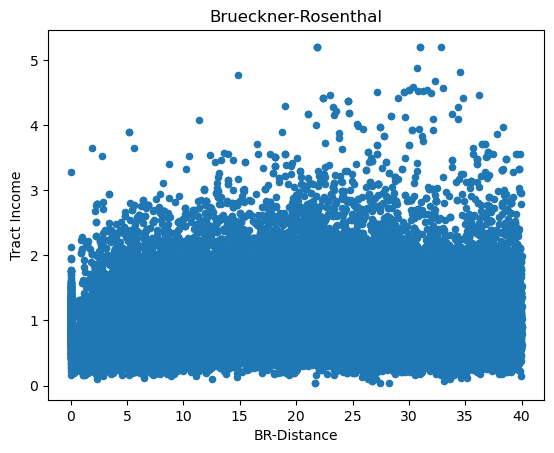

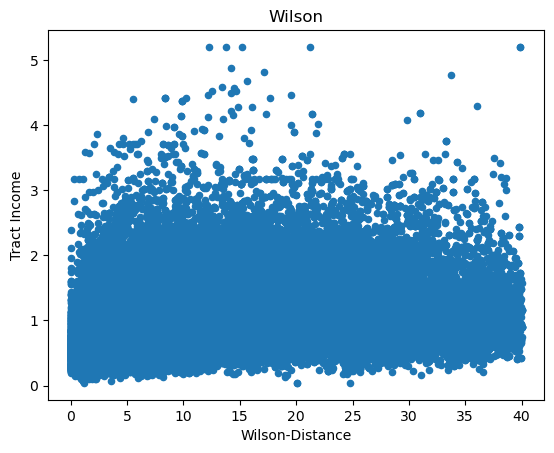

In [188]:
from matplotlib import pyplot as plt

br.plot(kind='scatter', x='distance', y='income', xlabel='BR-Distance', ylabel='Tract Income', title='Brueckner-Rosenthal')
wilson.plot(kind='scatter', x='distance', y='income', xlabel='Wilson-Distance', ylabel='Tract Income', title='Wilson')

Text(0.5, 1.0, 'Brueckner-Rosenthal')

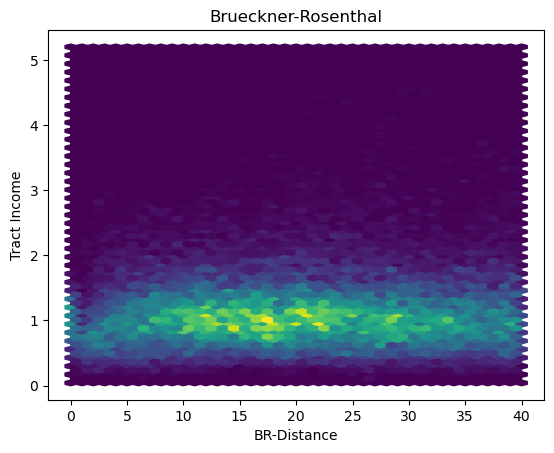

In [189]:
plt.hexbin(x=br['distance'], y=br['income'], gridsize=(40, 40))
plt.xlabel('BR-Distance')
plt.ylabel('Tract Income')
plt.title('Brueckner-Rosenthal')

Text(0.5, 1.0, 'Wilson')

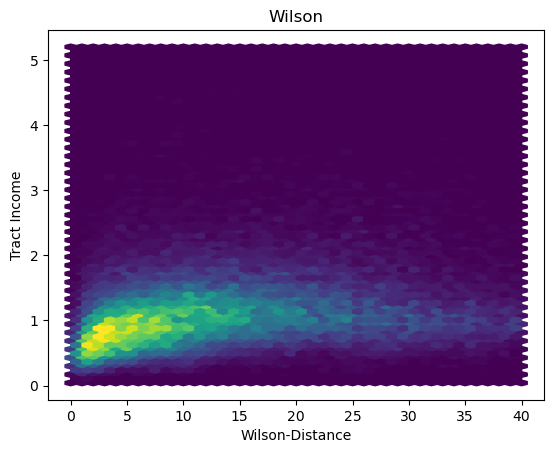

In [190]:
plt.hexbin(x=wilson['distance'], y=wilson['income'], gridsize=(40, 40))
plt.xlabel('Wilson-Distance')
plt.ylabel('Tract Income')
plt.title('Wilson')

In [191]:
def add_tract_counts(df: pd.DataFrame) -> pd.DataFrame:
    tract_counts =df.groupby('msa_code').count()['income']
    tract_counts = tract_counts.reset_index().rename({'income': 'tract_counts'}, axis=1)
    return pd.merge(right=df, left=tract_counts, left_on='msa_code', right_on='msa_code')

def discretize_distances(df: pd.DataFrame) -> pd.DataFrame:
    df['dist_bin'] = df['distance'].round()
    return df

def split_df_by_tract_counts(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    under_100 = df[df['tract_counts'] < 100]
    btw_100_500 = df[(df['tract_counts'] >= 100) & (df['tract_counts'] < 500)]
    btw_500_1000 = df[(df['tract_counts'] >= 500) & (df['tract_counts'] < 1000)]
    larger_1000 = df[df['tract_counts'] >= 1000]

    return (under_100, btw_100_500, btw_500_1000, larger_1000)

def plot_relative_income(df: pd.DataFrame, title: str, dist: str) -> None:
    df_dist_inc = df.groupby('dist_bin').mean()['income']
    plt.plot((df_dist_inc - df_dist_inc[0]) / df_dist_inc[0])
    plt.xlabel(f'{dist}-Distance from CBD (mi)')
    plt.ylabel('Median Income Compared to Mile Zero')
    plt.title(title)

def plot_housing_dist(df: pd.DataFrame) -> None:
    df.groupby('dist_bin').mean()[
    ['built_1999_2000', 
        'built_1995_1998', 
        'built_1990_1994', 
        'built_1980_1989', 
        'built_1970_1979', 
        'built_1960_1969', 
        'built_1950_1959', 
        'built_1940_1949', 
        'built_1939_earlier']
    ].plot(xlabel='Distance from CBD (mi)', ylabel='Mean Share of Housing Age')

def process_dataframe(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    return split_df_by_tract_counts(discretize_distances(add_tract_counts(df)))

In [192]:
under_100_br, btw_100_500_br, btw_500_1000_br, larger_1000_br = process_dataframe(br)
under_100_wilson, btw_100_500_wilson, btw_500_1000_wilson, larger_1000_wilson = process_dataframe(wilson)

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


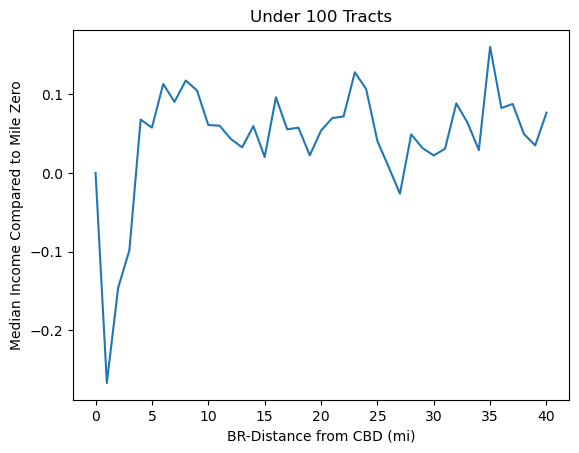

In [193]:
plot_relative_income(under_100_br, 'Under 100 Tracts', 'BR')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


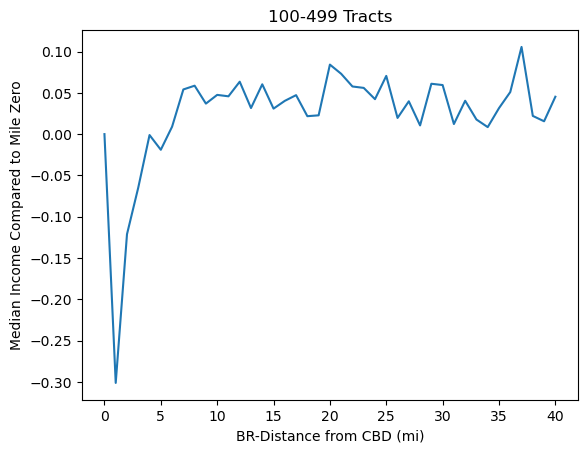

In [194]:
plot_relative_income(btw_100_500_br, '100-499 Tracts', 'BR')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


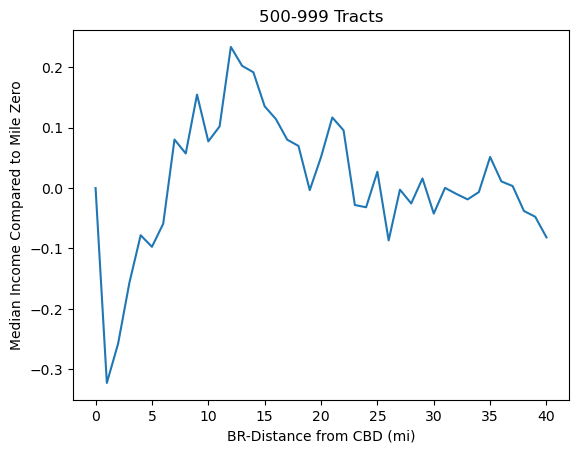

In [195]:
plot_relative_income(btw_500_1000_br, '500-999 Tracts', 'BR')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


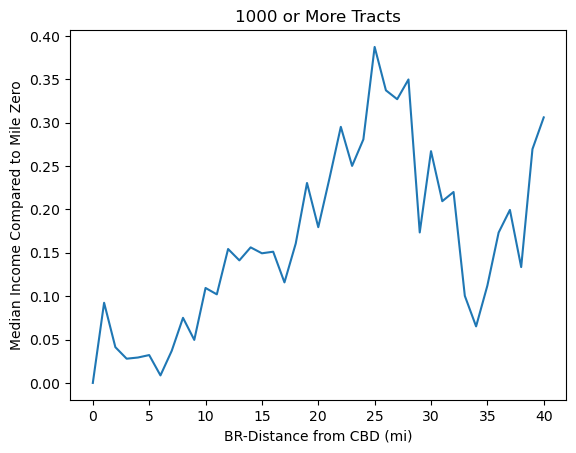

In [196]:
plot_relative_income(larger_1000_br, '1000 or More Tracts', 'BR')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


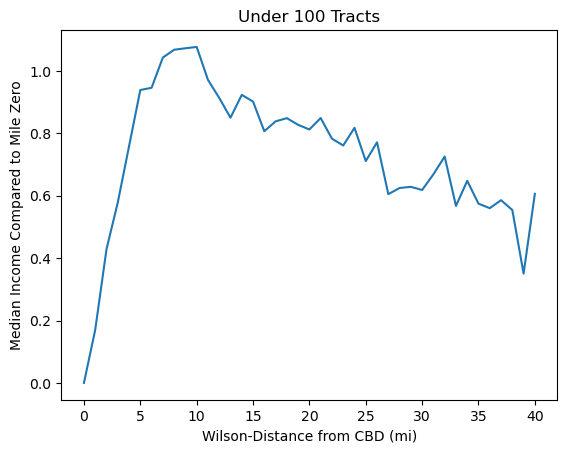

In [197]:
plot_relative_income(under_100_wilson, 'Under 100 Tracts', 'Wilson')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


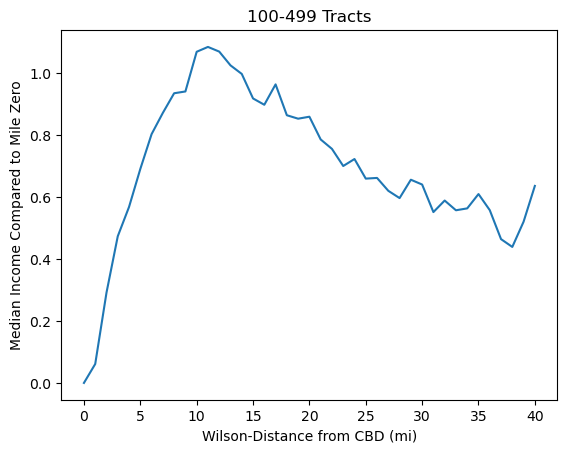

In [198]:
plot_relative_income(btw_100_500_wilson, '100-499 Tracts', 'Wilson')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


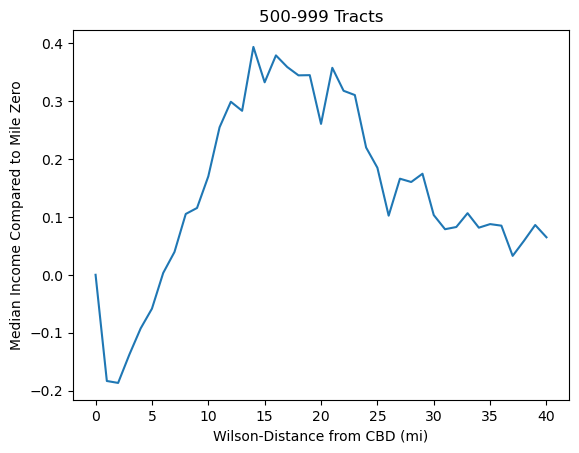

In [199]:
plot_relative_income(btw_500_1000_wilson, '500-999 Tracts', 'Wilson')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


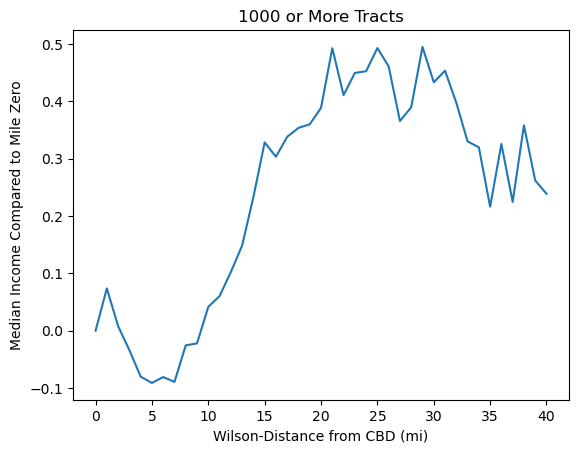

In [200]:
plot_relative_income(larger_1000_wilson, '1000 or More Tracts', 'Wilson')

/tmp/ipykernel_2697/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


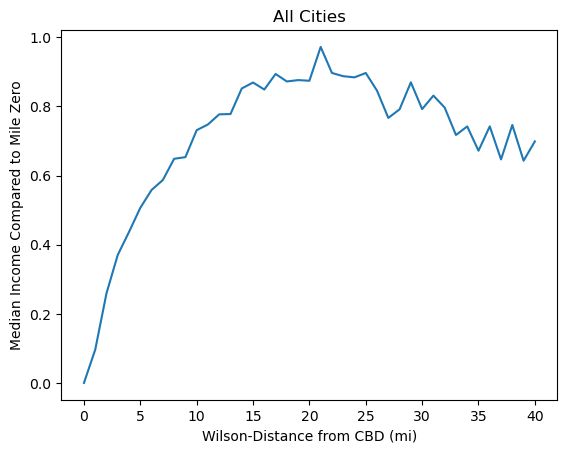

In [202]:
plot_relative_income(discretize_distances(wilson), 'All Cities', 'Wilson')

## Mapping

In [203]:
def geofy_data(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    ca_geo = geopandas.read_file('./data/CA_shapefile/tl_2010_06_tract00.shp')
    ca_geo = ca_geo[['CTIDFP00', 'geometry']]

    ca_geo['CTIDFP00'] = ca_geo['CTIDFP00'].astype(str).str.removeprefix('0')
    df['tract_id_2010'] = df['tract_id_2010'].astype(str)

    ca_geo = pd.merge(left=ca_geo, right=df, left_on='CTIDFP00', right_on='tract_id_2010')
    return ca_geo.dropna()